## Import Libraries

In [66]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

## Data Wrangling

#### Import Files

In [67]:
data = pd.read_csv(r"C:\Users\jolis\Documents\Cert\Quantium\QVI_data.csv")


In [68]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


## Data Cleaning

#### Data Cleaning of the 'PROD_NAME' column

In [69]:
data.dtypes

LYLTY_CARD_NBR        int64
DATE                 object
STORE_NBR             int64
TXN_ID                int64
PROD_NBR              int64
PROD_NAME            object
PROD_QTY              int64
TOT_SALES           float64
PACK_SIZE             int64
BRAND                object
LIFESTAGE            object
PREMIUM_CUSTOMER     object
dtype: object

In [70]:
data['DATE'] = pd.to_datetime(data['DATE'])
data['PROD_NAME'].str.strip()
data['PROD_NAME'] = data['PROD_NAME'].str.replace(r'\s{2,}', ' ', regex=True)  # Replace multiple spaces with one
data['PROD_NAME'] = data['PROD_NAME'].str.replace(r'(?<!\b[A-Z])([a-z])([A-Z])', r'\1 \2', regex=True)  # Add space before uppercase letters, ignoring consecutive uppercase letters    
data['PROD_NAME'] = data['PROD_NAME'].str.replace(r'&', ' & ', regex=False)  # Add space before and after '&'

## Control Store Selection

The client has selected store numbers 77, 86 and 88 as trial stores and want 
control stores to be established stores that are operational for the entire 
observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer


Using Pearson correlations or a metric such as a magnitude distance e.g. 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance) as a measure.

In [71]:
# 1. Add a Month ID column in the format yyyymm
data['Month_ID'] = pd.to_datetime(data['DATE']).dt.strftime('%Y%m')

# 2. Filter the data for the pre-trial period (up to February 2019)
pre_trial_data = data[data['DATE'] <= '2019-02-28']

# 3. Calculate the monthly metrics for each store
monthly_metrics = pre_trial_data.groupby(['STORE_NBR', 'Month_ID']).agg(
    total_sales=('TOT_SALES', 'sum'),
    num_customers=('LYLTY_CARD_NBR', 'nunique'),
    num_transactions=('TXN_ID', 'nunique'),
    total_qty=('PROD_QTY', 'sum')
).reset_index()

# 4. Filter to ensure stores are operational throughout the pre-trial period
operational_stores = monthly_metrics.groupby('STORE_NBR').filter(lambda x: len(x) == len(monthly_metrics['Month_ID'].unique()))

# Now, operational_stores contains the stores that are operational throughout the pre-trial period


In [72]:
# 1. Calculate transactions per customer
monthly_metrics['transactions_per_customer'] = monthly_metrics['num_transactions'] / monthly_metrics['num_customers']

# 2. Calculate chips per customer
monthly_metrics['chips_per_customer'] = monthly_metrics['total_qty'] / monthly_metrics['num_customers']

# 3. Calculate the average price per unit
monthly_metrics['avg_price_per_unit'] = monthly_metrics['total_sales'] / monthly_metrics['total_qty']

# 4. Filter to ensure stores are operational throughout the pre-trial period
operational_stores = monthly_metrics.groupby('STORE_NBR').filter(lambda x: len(x) == len(monthly_metrics['Month_ID'].unique()))

# Now, operational_stores contains the stores with full observation periods


In [73]:
monthly_metrics

,STORE_NBR,Month_ID,total_sales,num_customers,num_transactions,total_qty,transactions_per_customer,chips_per_customer,avg_price_per_unit
0,1,201807,206.9,49,52,62,1.061224,1.265306,3.337097
1,1,201808,176.1,42,43,54,1.023810,1.285714,3.261111
2,1,201809,278.8,59,62,75,1.050847,1.271186,3.717333
3,1,201810,188.1,44,45,58,1.022727,1.318182,3.243103
4,1,201811,192.6,46,47,57,1.021739,1.239130,3.378947
...,...,...,...,...,...,...,...,...,...
2107,272,201810,430.6,44,50,99,1.136364,2.250000,4.349495
2108,272,201811,376.2,41,45,87,1.097561,2.121951,4.324138
2109,272,201812,403.9,47,47,89,1.000000,1.893617,4.538202
2110,272,201901,423.0,46,50,96,1.086957,2.086957,4.406250


#### Function to Calculate Correlation

In [74]:
def calculate_correlation(metric_table, metric_col, store_comparison):
    """
    Calculate correlation for a given metric column between trial store and each control store.

    :param metric_table: DataFrame containing the metrics for all stores.
    :param metric_col: The column name in metric_table that contains the metric to compare (e.g., 'total_sales').
    :param store_comparison: The store number of the trial store to compare against control stores.

    :return: DataFrame with store numbers and their correlation to the trial store.
    """
    # Filter data for the trial store
    trial_store_data = metric_table[metric_table['STORE_NBR'] == store_comparison][['Month_ID', metric_col]].set_index('Month_ID')
    trial_store_data = trial_store_data.rename(columns={metric_col: 'trial_metric'})

    # Merge trial store data with the rest of the metric table
    comparison_data = metric_table[['STORE_NBR', 'Month_ID', metric_col]].merge(
        trial_store_data, left_on='Month_ID', right_index=True
    )

    # Group by each control store and calculate correlation
    def compute_corr(group):
        return group[metric_col].corr(group['trial_metric'])

    correlation_results = (
        comparison_data.groupby('STORE_NBR').apply(compute_corr).reset_index(name='correlation')
    )
    
    return correlation_results


#### Function to Calculate Standardised Magnitude Distance

In [75]:
def calculate_standardised_magnitude_distance(metric_table, metric_col, store_comparison):
    """
    Calculate standardised magnitude distance between the trial store and each control store for a given metric.

    :param metric_table: DataFrame containing the metrics for all stores.
    :param metric_col: The column name in metric_table that contains the metric to compare (e.g., 'total_sales').
    :param store_comparison: The store number of the trial store to compare against control stores.

    :return: DataFrame with store numbers and their standardised magnitude distance.
    """
    # Filter out the data for the trial store and control stores
    trial_store_data = metric_table[metric_table['STORE_NBR'] == store_comparison][['Month_ID', metric_col]]
    
    # Merge trial store data with metric table to get the comparison for each control store
    comparison_data = metric_table[['STORE_NBR', 'Month_ID', metric_col]].merge(trial_store_data, on='Month_ID', suffixes=('', '_trial'))
    
    # Calculate the absolute difference between trial store and control store for each month
    comparison_data['magnitude_diff'] = abs(comparison_data[metric_col] - comparison_data[f'{metric_col}_trial'])
    
    # Calculate the standardised magnitude distance by dividing by the max possible difference
    max_diff = comparison_data['magnitude_diff'].max()
    comparison_data['standardised_distance'] = comparison_data['magnitude_diff'] / max_diff
    
    # Group by control stores and return the average standardised distance
    standardised_distance_results = comparison_data.groupby('STORE_NBR')['standardised_distance'].mean().reset_index()
    return standardised_distance_results

####

In [76]:
# Example of calling the functions
metric_col = 'total_sales'  # Change to the desired metric
store_comparison = 77  # Trial store number

correlation_results = calculate_correlation(monthly_metrics, metric_col, store_comparison)
standardised_distance_results = calculate_standardised_magnitude_distance(monthly_metrics, metric_col, store_comparison)

# Print results
print(correlation_results)
print(standardised_distance_results)


     STORE_NBR  correlation
0            1     0.050163
1            2    -0.200796
2            3     0.616574
3            4    -0.094125
4            5    -0.045765
..         ...          ...
266        268     0.350807
267        269    -0.315842
268        270     0.324937
269        271     0.362891
270        272     0.114645

[271 rows x 2 columns]
     STORE_NBR  standardised_distance
0            1               0.038506
1            2               0.059802
2            3               0.609589
3            4               0.725095
4            5               0.406944
..         ...                    ...
266        268               0.037748
267        269               0.510459
268        270               0.505670
269        271               0.410948
270        272               0.108261

[271 rows x 2 columns]


c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\jolis\AppData\Local\Temp\ipykernel_2848\1739762420.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comparison_data.groupby('STORE_NBR').apply(compute_corr).reset_index(name='correlation')


In [77]:
# Check for stores with insufficient data
insufficient_data = monthly_metrics.groupby('STORE_NBR').size()
print(insufficient_data[insufficient_data < 2])

# Drop stores with fewer than 2 observations
valid_stores = insufficient_data[insufficient_data >= 2].index
monthly_metrics = monthly_metrics[monthly_metrics['STORE_NBR'].isin(valid_stores)]


STORE_NBR
76     1
85     1
206    1
211    1
252    1
dtype: int64


##### Composite Score Calculation

In [78]:
# Define the trial store number
store_comparison = 77

# Calculate correlation and magnitude distance for 'total_sales'
corr_sales = calculate_correlation(monthly_metrics, 'total_sales', store_comparison)
mag_sales = calculate_standardised_magnitude_distance(monthly_metrics, 'total_sales', store_comparison)

# Calculate correlation and magnitude distance for 'num_customers'
corr_customers = calculate_correlation(monthly_metrics, 'num_customers', store_comparison)
mag_customers = calculate_standardised_magnitude_distance(monthly_metrics, 'num_customers', store_comparison)

# Rename columns for clarity
corr_sales = corr_sales.rename(columns={'correlation': 'correlation_sales'})
mag_sales = mag_sales.rename(columns={'standardised_distance': 'standardised_distance_sales'})

corr_customers = corr_customers.rename(columns={'correlation': 'correlation_customers'})
mag_customers = mag_customers.rename(columns={'standardised_distance': 'standardised_distance_customers'})

# Merge total sales metrics
combined_sales = pd.merge(corr_sales, mag_sales, on='STORE_NBR')

# Merge customer metrics
combined_customers = pd.merge(corr_customers, mag_customers, on='STORE_NBR')

# Merge sales and customer scores
combined_scores = pd.merge(combined_sales, combined_customers, on='STORE_NBR')

# Calculate combined score
combined_scores['combined_score'] = (
    0.25 * combined_scores['correlation_sales'] +
    0.25 * combined_scores['standardised_distance_sales'] +
    0.25 * combined_scores['correlation_customers'] +
    0.25 * combined_scores['standardised_distance_customers']
)

# Sort and display top-ranked stores
combined_scores_sorted = combined_scores.sort_values(by='combined_score', ascending=False)
combined_scores_sorted.head()


C:\Users\jolis\AppData\Local\Temp\ipykernel_2848\1739762420.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comparison_data.groupby('STORE_NBR').apply(compute_corr).reset_index(name='correlation')
c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\jolis\AppData\Local\Temp\ipykernel_2848\1739762420.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of p

,STORE_NBR,correlation_sales,standardised_distance_sales,correlation_customers,standardised_distance_customers,combined_score
115,119,0.831832,0.526925,0.977709,0.532452,0.717229
231,237,0.518115,0.793633,0.602572,0.801683,0.679001
70,71,0.792931,0.514751,0.719435,0.596154,0.655818
2,3,0.616574,0.609589,0.756913,0.620192,0.650817
244,250,0.536820,0.615492,0.584932,0.640625,0.594467


To combine the scores and select the most appropriate control store for trial store 77

In [79]:
# Define correlation weight
corr_weight = 0.5

# Calculate combined score for sales
combined_scores['scoreNSales'] = (
    corr_weight * combined_scores['correlation_sales'] +
    (1 - corr_weight) * combined_scores['standardised_distance_sales']
)

# Calculate combined score for customers
combined_scores['scoreNCust'] = (
    corr_weight * combined_scores['correlation_customers'] +
    (1 - corr_weight) * combined_scores['standardised_distance_customers']
)

# Calculate the final control score
combined_scores['finalControlScore'] = (
    0.5 * combined_scores['scoreNSales'] +
    0.5 * combined_scores['scoreNCust']
)

# Filter out the trial store and rank by final score
control_candidates = combined_scores[combined_scores['STORE_NBR'] != 77]
control_candidates_sorted = control_candidates.sort_values(by='finalControlScore', ascending=False)

# Select the second-highest-ranked control store
best_control_store = control_candidates_sorted.iloc[1]  # Second-ranked store
print("Most appropriate control store for trial store 77:")
print(best_control_store)


Most appropriate control store for trial store 77:
STORE_NBR                          237.000000
correlation_sales                    0.518115
standardised_distance_sales          0.793633
correlation_customers                0.602572
standardised_distance_customers      0.801683
combined_score                       0.679001
scoreNSales                          0.655874
scoreNCust                           0.702127
finalControlScore                    0.679001
Name: 231, dtype: float64


C:\Users\jolis\AppData\Local\Temp\ipykernel_2848\955801885.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Store_Type'] = plot_data['STORE_NBR'].apply(


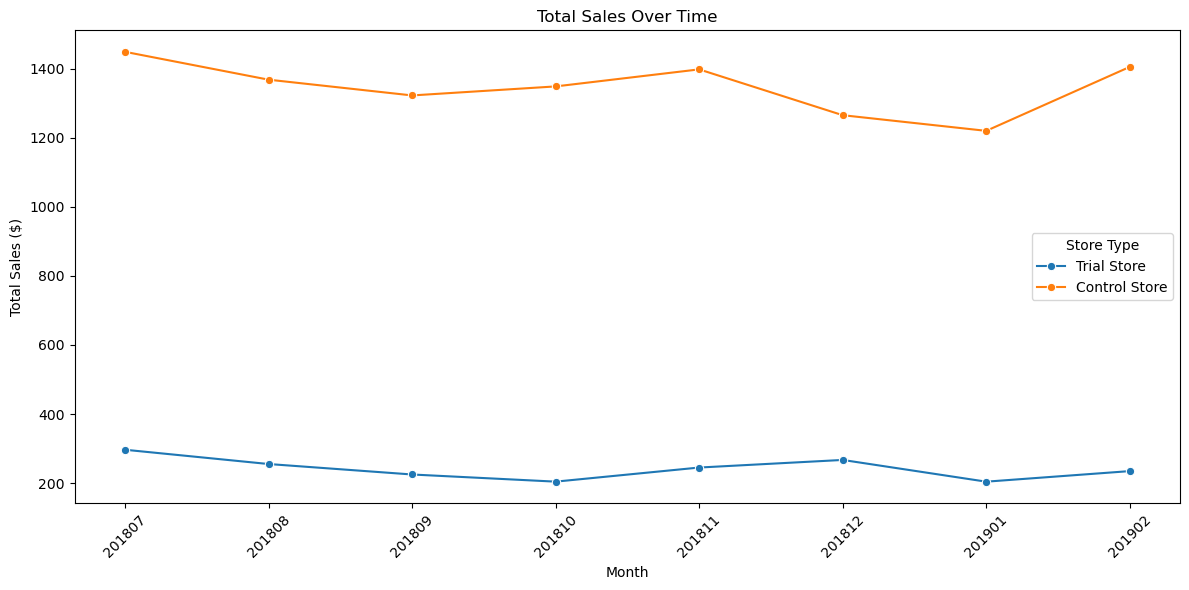

In [80]:
relevant_stores = [store_comparison, best_control_store['STORE_NBR']]  # Add other stores if needed
plot_data = monthly_metrics[monthly_metrics['STORE_NBR'].isin(relevant_stores)]
plot_data['Store_Type'] = plot_data['STORE_NBR'].apply(
    lambda x: 'Trial Store' if x == store_comparison else 
              ('Control Store' if x == best_control_store['STORE_NBR'] else 'Other Stores')
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_data, x='Month_ID', y='total_sales', hue='Store_Type', marker='o')
plt.title('Total Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.legend(title='Store Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Assessment of trial

In [81]:

plot_data['Month_ID'] = plot_data['Month_ID'].astype(int)

C:\Users\jolis\AppData\Local\Temp\ipykernel_2848\3038340166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Month_ID'] = plot_data['Month_ID'].astype(int)


In [82]:
# Assuming store_comparison, best_control_store, and plot_data are defined

# Filter data for the pre-trial period (January 2019 and before)
pre_trial_period = plot_data[plot_data['Month_ID'] < 201902]

# Calculate the percentage differences for the pre-trial period
pre_trial_comparison_df = pd.merge(
    pre_trial_period[pre_trial_period['STORE_NBR'] == store_comparison][['Month_ID', 'total_sales']], 
    pre_trial_period[pre_trial_period['STORE_NBR'] == best_control_store['STORE_NBR']][['Month_ID', 'total_sales']], 
    on='Month_ID', suffixes=('_trial', '_control')
)

pre_trial_comparison_df['percentage_difference'] = (
    (pre_trial_comparison_df['total_sales_control'] - pre_trial_comparison_df['total_sales_trial']) / pre_trial_comparison_df['total_sales_trial'] * 100
)

# Calculate the standard deviation of the pre-trial percentage differences
std_dev_pre_trial = pre_trial_comparison_df['percentage_difference'].std()

# Number of months in the trial period
n_trial_months = len(plot_data[(plot_data['Month_ID'] >= 201902) & (plot_data['STORE_NBR'] == store_comparison)])

# Calculate the mean of the percentage differences for the trial period
trial_period = plot_data[(plot_data['Month_ID'] >= 201902) & (plot_data['Month_ID'] < 201905)]
comparison_df = pd.merge(
    trial_period[trial_period['STORE_NBR'] == store_comparison][['Month_ID', 'total_sales']], 
    trial_period[trial_period['STORE_NBR'] == best_control_store['STORE_NBR']][['Month_ID', 'total_sales']], 
    on='Month_ID', suffixes=('_trial', '_control')
)
comparison_df['percentage_difference'] = (
    (comparison_df['total_sales_control'] - comparison_df['total_sales_trial']) / comparison_df['total_sales_trial'] * 100
)
mean_percentage_difference_trial = comparison_df['percentage_difference'].mean()

# Null hypothesis mean is 0 (no difference)
mu = 0

# Calculate the t-value for the trial period
t_value = (mean_percentage_difference_trial - mu) / (std_dev_pre_trial / np.sqrt(n_trial_months))

# Degrees of freedom
df = len(pre_trial_comparison_df) - 1  # 7 degrees of freedom for the pre-trial period

# Get the 95th percentile critical t-value from the t-distribution
t_critical = stats.t.ppf(0.95, df)

# Print the t-value and the critical t-value
print(f"T-Value: {t_value}")
print(f"Critical T-Value (95th percentile): {t_critical}")

# Determine if the result is significant
if abs(t_value) > t_critical:
    print("The difference is statistically significant!")
else:
    print("The difference is not statistically significant.")

T-Value: 7.659221915908345
Critical T-Value (95th percentile): 1.9431802805153022
The difference is statistically significant!


C:\Users\jolis\AppData\Local\Temp\ipykernel_2848\1154615487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Store_type'] = plot_data['STORE_NBR'].apply(
C:\Users\jolis\AppData\Local\Temp\ipykernel_2848\1154615487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['totSales'] = plot_data['total_sales']
C:\Users\jolis\AppData\Local\Temp\ipykernel_2848\1154615487.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

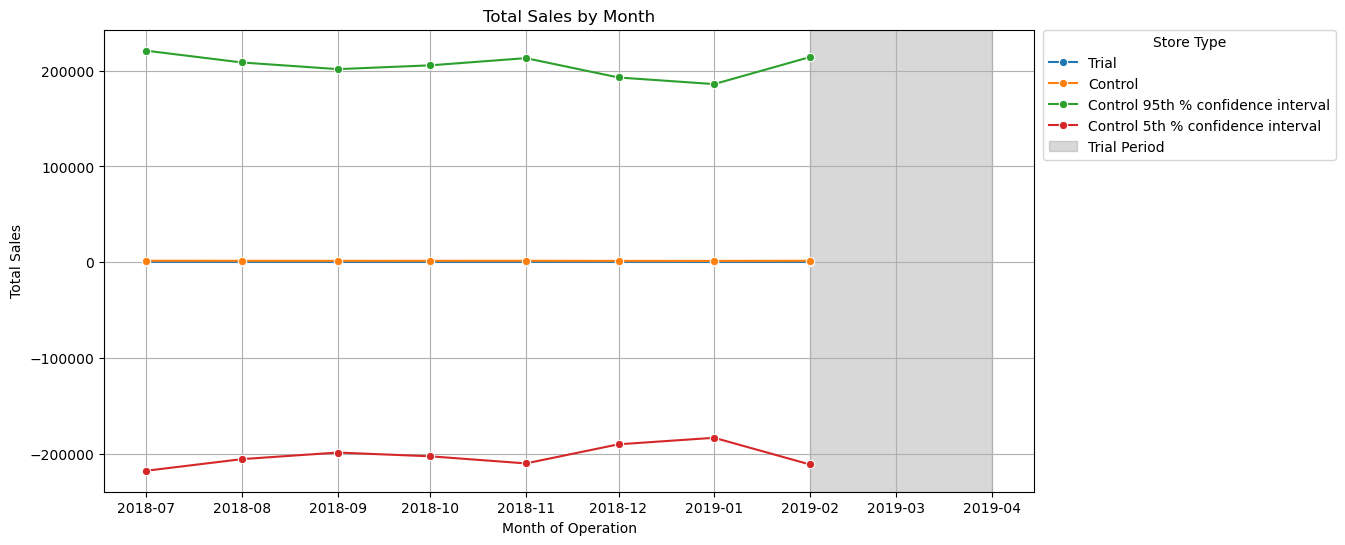

In [87]:
# Create new variables
plot_data['Store_type'] = plot_data['STORE_NBR'].apply(
    lambda x: 'Trial' if x == store_comparison else 'Control'
)
plot_data['totSales'] = plot_data['total_sales']
plot_data['TransactionMonth'] = pd.to_datetime(plot_data['Month_ID'].astype(str), format='%Y%m')

# Filter for trial and control stores
filtered_data = plot_data[plot_data['Store_type'].isin(['Trial', 'Control'])]

# Calculate confidence intervals for Control Store
stdDev = filtered_data[filtered_data['Store_type'] == 'Control']['totSales'].std()
meanSales = filtered_data[filtered_data['Store_type'] == 'Control']['totSales'].mean()

# 95th Percentile
control_95th = filtered_data[filtered_data['Store_type'] == 'Control'].copy()
control_95th['totSales'] = control_95th['totSales'] * (1 + stdDev * 2)
control_95th['Store_type'] = 'Control 95th % confidence interval'

# 5th Percentile
control_5th = filtered_data[filtered_data['Store_type'] == 'Control'].copy()
control_5th['totSales'] = control_5th['totSales'] * (1 - stdDev * 2)
control_5th['Store_type'] = 'Control 5th % confidence interval'

# Combine data
trial_assessment = pd.concat([filtered_data, control_95th, control_5th])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=trial_assessment,
    x='TransactionMonth',
    y='totSales',
    hue='Store_type',
    marker='o'
)
plt.axvspan(pd.to_datetime('2019-02'), pd.to_datetime('2019-04'), color='gray', alpha=0.3, label='Trial Period')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(title='Store Type', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.grid(True)

plt.show()
